# Проект. Selfie Segmentation

**Введение**

Selfie Segmentation -  выделения портретного изображения человека на картинке. Используется в задачи наложения фона в видео конференции. Модели, основанные на нейронных сетях, на первом этапе получают маску изображения - матрицу с размерами входного изображения, в которой записаны значения от 0 до 1. Чем больше значения элементов матриц тем вероятнее в этом месте находится портретное изображение человека. Далее на основе этой матрицы реальный фон на картинке заменяется на другое изображение. Такие модели должны не только качественно рассчитывать маску, но и делать это максимально быстро на ограниченном в ресурсах устройстве. При видеоконференции обычно используется частота 15-30 кадров в секунду. Модель даже на мобильном устройстве не должна тратить слишком много времени для получения маски, чтобы можно было поддерживать приемлемую частоту кадров.

**Цель:** Подобрать лучшую модель для задачи наложения фона в видео конференции.

**Задачи:**
* выбрать метрики качества для сравнения моделей;
* выбрать модели selfie segmentation для сравнения;
* получить метрики качества для каждой модели на основе датасета;
* сделать сравнительный анализ метрик качества;
* выбрать модель с наилучшими метриками качества;
* продемонстрировать наложение фона.


**Датасет:** https://www.kaggle.com/code/vbookshelf/selfie-segmenter-keras-and-u-net

**Выполнил:** Попов Виктор Борисович

### Подготовка данных

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from matplotlib.cbook import boxplot_stats

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import ipywidgets as widgets
import threading
from keras.models import load_model
import mediapipe as mp
import tensorflow as tf
from models.SINet import *
from torchvision import transforms
from sklearn.metrics import jaccard_score # То же самое, что и IoU
import time

Создание таблицы для соотношения путей к RGB и ARGB изображениям

In [4]:
image_dir = 'dataset/clip_img'
mask_dir  = 'dataset/matting'
image_mask_list = []
try:
    for (subdir_image, dirs_image, files_image), (subdir_mask, dirs_mask, files_mask) in zip(os.walk(image_dir), os.walk(mask_dir)):
        for file_image, file_mask in zip(files_image, files_mask):
            image_mask_list.append([os.path.join(subdir_image, file_image), os.path.join(subdir_mask, file_mask)])
            if os.path.splitext(file_image)[0] != os.path.splitext(file_mask)[0]:
                print("Error: image name \"{}\" and mask name \"{}\" are different".format(image_mask_list[-1][0], image_mask_list[-1][1]))
                raise FileNotFoundError
except FileNotFoundError:
    pass

image_mask_df = pd.DataFrame(image_mask_list, columns=['image_path', 'mask_path'])
dataset_size = image_mask_df.shape[0]
print("Found {} image-mask pairs".format(dataset_size))
image_mask_df.head()

Found 34426 image-mask pairs


image_path  \
0  dataset/clip_img\1803151818\clip_00000000\1803...   
1  dataset/clip_img\1803151818\clip_00000000\1803...   
2  dataset/clip_img\1803151818\clip_00000000\1803...   
3  dataset/clip_img\1803151818\clip_00000000\1803...   
4  dataset/clip_img\1803151818\clip_00000000\1803...   

                                           mask_path  
0  dataset/matting\1803151818\matting_00000000\18...  
1  dataset/matting\1803151818\matting_00000000\18...  
2  dataset/matting\1803151818\matting_00000000\18...  
3  dataset/matting\1803151818\matting_00000000\18...  
4  dataset/matting\1803151818\matting_00000000\18...

Примеры из датасета

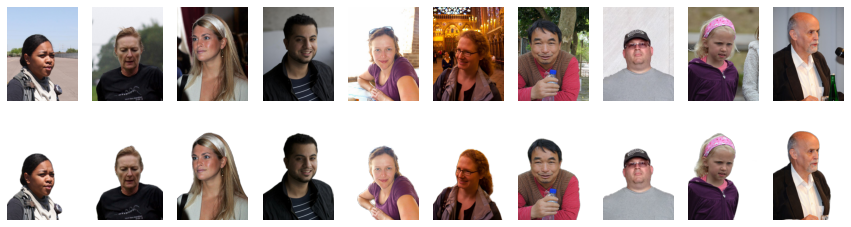

In [5]:
random.seed(0)
n = 10
fig, axs = plt.subplots(nrows=2, ncols=n, figsize=(15,4))
for i in range(n):
    image_mask_index = random.randrange(dataset_size)
    ax = axs[0, i]
    image = plt.imread(image_mask_df.iloc[image_mask_index]['image_path'])
    ax.imshow(image)
    ax.axis('off')
    ax = axs[1, i]
    mask = plt.imread(image_mask_df.iloc[image_mask_index]['mask_path'])
    ax.imshow(mask)
    ax.axis('off')

plt.show()

### Описание датасета
- 34426 RGB изображений людей в формате jpg - размер: (600, 800, 3)
- 34426 RGBA изображений людей без фона в формате png - размер: (600, 800, 4)

RGB изображения имеют 3 цветовых канала с целочисленными значениями в диапазоне [0; 225], RGBA изображения имеют 4 канала: 3 цветовых и 1 альфа (прозрачность пикселей) с вещественными значениями в диапазоне [0; 1]. 0 - это полностью прозрачный. 1 - это полностью видимый. 

Посмотрим как выглядит альфа канал, маска с порогом 0.5 и изображение с применением маски.

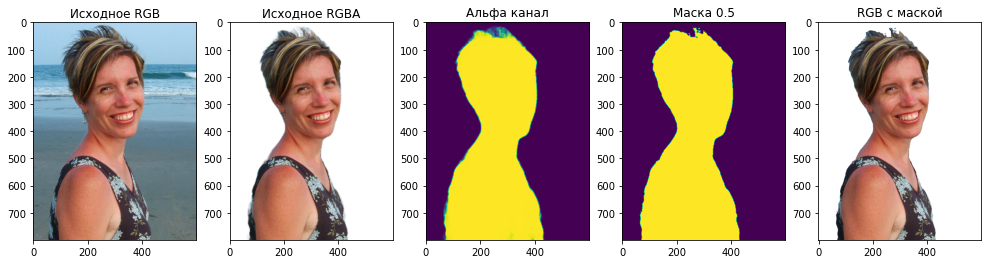

In [6]:
random.seed(3)

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(17,4))

image_mask_index = random.randrange(dataset_size)

rgb_image = plt.imread(image_mask_df.iloc[image_mask_index]['image_path'])
rgba_image = plt.imread(image_mask_df.iloc[image_mask_index]['mask_path'])

# выделим 4-ый канал
alpha = rgba_image[:,:,3]
# выделем маску на уровне 0.5 и переведём её в диапазон 0-255
mask = (alpha > 0.5).astype(np.uint8) * 255
# выделим объект на изображении при помощи маски
segmented_selfie =  np.dstack((rgb_image, mask))

axs[0].imshow(rgb_image)
axs[0].set_title("Исходное RGB")
axs[1].imshow(rgba_image)
axs[1].set_title("Исходное RGBA")
axs[2].imshow(alpha)
axs[2].set_title("Альфа канал")
axs[3].imshow(mask)
axs[3].set_title("Маска 0.5")
axs[4].imshow(segmented_selfie)
axs[4].set_title("RGB с маской")

plt.show()

### Метрики качества

#### Пересечение над объединением (IoU - Intersection over Union)
***IoU*** используется для определения качества моделей нахождения (Object Detection) и выделения (Segmentation) объектов на изображении. Этот параметр оценивает перекрытие реальной области нахождения объекта и предсказанной маски.

<img src="img/Understanding-Intersection-Over-Union-in-Object-Detection-and-Segmentation.webp">

Для вычисления ***IoU*** используется попиксельный анализ представленный ниже. Площадь области в данном случае вычисляется сложением пикселей, находяжихся в данной области.  

***True Positive:*** Площадь пересечения реальной области (Ground Truth - GT) и предсказанной маски (Segmentation - S). Математически выражается логической операцией ***И*** между ***GT*** и ***S***: <img src="img/True-Positive.png" width="120">
<br>
***False Positive:*** Площадь предсказанной маски, которая не пересекается с реально областью. Это можно выразить логическим ***ИЛИ*** между ***GT*** и ***S*** минус ***GT***: <img src="img/False-Positive.webp" width="200">
<br>
***False Negative:*** Площадь внутри реальной области, которую не верно предсказала модель. Это можно выразить логическим ***ИЛИ*** между ***GT*** и ***S*** минус ***S***:<img src="img/False-Negative.png" width="180">
<br>
***IoU*** выражается как отношение площади пересечения реальной области с объектом и предсказанной маски к объединённой площади:
<img src="img/Intersection-over-Union-IoU-in-Object-Detection-and-Segmentation-formula.webp" width="220">
<br>
Иллюстрация ***TP***, ***FP*** и ***FN***:
<img src="img/5-segmentation-iou.webp">


Подробнее о ***IoT***: https://learnopencv.com/intersection-over-union-iou-in-object-detection-and-segmentation/


#### Время расчёта маски
Для задачи наложения виртуального фона важным показателем является время расчёта маски сегментации на различных устройствах, в том числе мобильных. Во время видеоконференций расчёт маски будет происходить на устройстве. Это может быть персональный компьютер или смартфон. Стандартная частота кадров в видео конференциях 30 кадров в секунду. Соответственно для обеспечения такой частоты кадров время расчёта маски не должно превышать 33 милисекунд. Приемлимой может быть частота кадров 15 кадров в секунду и максимальное время расчёта менее 66 мс. В худшем случае 7,5 кадров в секунду и максимальное время расчёта 132 мс. При дольшем расчёте видео не будет приемлимого качества и общаться будет не удобно.
Время расчёта маски будет вычисляться на достаточно мощном ПК HP ZBook Power G7 с процессором Intel(R) Core(TM) i7-10750H 2.60GHz. 

# Модели

Наложение фона по маске

In [7]:
def merge_with_background(rgb_image, mask, rgb_background):
    fg = cv2.bitwise_or(rgb_image, rgb_image, mask=mask)
    bg = cv2.bitwise_or(rgb_background, rgb_background, mask=~mask)
    out = cv2.bitwise_or(fg, bg)
    return out

Получение истинной маски

In [8]:
def get_true_mask(image_mask_index):
    rgba_image = plt.imread(image_mask_df.iloc[image_mask_index]['mask_path'])
    # выделим 4-ый канал
    alpha = rgba_image[:,:,3]
    # выделем маску на уровне 0.5 и переведём её в диапазон 0-255
    return (alpha > 0.5).astype(np.uint8) * 255

Вычисление маски сегментации

In [9]:
def calc_pred_mask(model, image_mask_index):
    image = cv2.imread(image_mask_df.iloc[image_mask_index]['image_path'])
    
    start_time = time.time()
    mask = model.seg(image)
    calc_time = (time.time() - start_time) * 1000
        
    return (mask > 127).astype(np.uint8) * 255, calc_time

Функция для просмотра примеров наложения фона для конкретной модели

In [10]:
def show_example(model):
    random.seed(7)
    n = 10
    fig, axs = plt.subplots(nrows=3, ncols=n, figsize=(18,6))
    bgd = cv2.imread('./img/background.jpg')
    bgd = cv2.cvtColor(bgd, cv2.COLOR_BGR2RGB)
    bgd = cv2.resize(bgd, (600, 800))
    
    row_titles = ["Оригинал", "Правильная сегментация", "Сегментация модели {}".format(model.short_name())]
    for ax, row_title in zip(axs[:,0], row_titles):
        ax.annotate(row_title, xy=(0, 0.5), xytext=(0, 0.5), xycoords='axes fraction', textcoords='axes fraction',
                    size='large', ha='right', va='center')
    for i in range(n):
        image_mask_index = random.randrange(dataset_size)

        ax = axs[0, i]
        rgb_image = plt.imread(image_mask_df.iloc[image_mask_index]['image_path'])
        ax.imshow(rgb_image)
        ax.axis('off')

        ax = axs[1, i]
        true_mask = get_true_mask(image_mask_index)
        segmented_selfie_true = merge_with_background(rgb_image, true_mask, bgd)
        ax.imshow(segmented_selfie_true)
        ax.axis('off')

        ax = axs[2, i]
        pred_mask, calc_time = calc_pred_mask(model, image_mask_index)
        segmented_selfie_pred = merge_with_background(rgb_image, pred_mask, bgd)
        ax.imshow(segmented_selfie_pred)
        ax.axis('off')    

        print("IoU {:.2f}".format(jaccard_score(true_mask, pred_mask, average="micro")))
        print("Time of segmentation {:.0f} milliseconds".format(calc_time))
        
    fig.tight_layout()
    plt.show()

### MobileNet version 2

In [11]:
class SelfieSegMNV2:
    def __init__(self):
        # Initialize tflite-interpreter
        self.interpreter = tf.lite.Interpreter(model_path="models/deconv_fin_munet.tflite")
        self.interpreter.allocate_tensors()
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()
        self.input_shape = self.input_details[0]['shape'][1:3]

        # Image overlay
        self.overlay = np.zeros((self.input_shape[0], self.input_shape[1], 3), np.uint8)
        self.overlay[:] = (127, 0, 0)

    def short_name(self):
        return "MNV2"
    
    def seg(self, frame):
        # BGR->RGB, CV2->PIL
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(rgb)

        width = image.width
        height = image.height
        
        # Resize image
        image = image.resize(self.input_shape, Image.ANTIALIAS)

        # Normalization
        image = np.asarray(image)
        prepimg = image / 255.0
        prepimg = prepimg[np.newaxis, :, :, :]

        # Segmentation
        self.interpreter.set_tensor(self.input_details[0]['index'], np.array(prepimg, dtype=np.float32))
        self.interpreter.invoke()
        outputs = self.interpreter.get_tensor(self.output_details[0]['index'])

        # Process the output
        output = np.uint8(outputs[0] > 0.5)
        res = np.reshape(output, self.input_shape)
        mask = Image.fromarray(np.uint8(res), mode="P")
        mask = np.array(mask.convert("RGB")) * self.overlay
        mask = cv2.resize(np.asarray(mask), (width, height), interpolation=cv2.INTER_CUBIC)
        mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
        _, mask = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)
        # frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_CUBIC)

        return mask

In [12]:
segMNV2 = SelfieSegMNV2()

IoU 0.99
Time of segmentation 31 milliseconds
IoU 0.98
Time of segmentation 31 milliseconds
IoU 0.97
Time of segmentation 40 milliseconds
IoU 0.97
Time of segmentation 16 milliseconds
IoU 0.97
Time of segmentation 39 milliseconds
IoU 0.93
Time of segmentation 31 milliseconds
IoU 0.96
Time of segmentation 32 milliseconds
IoU 0.98
Time of segmentation 28 milliseconds
IoU 0.88
Time of segmentation 29 milliseconds
IoU 0.96
Time of segmentation 26 milliseconds


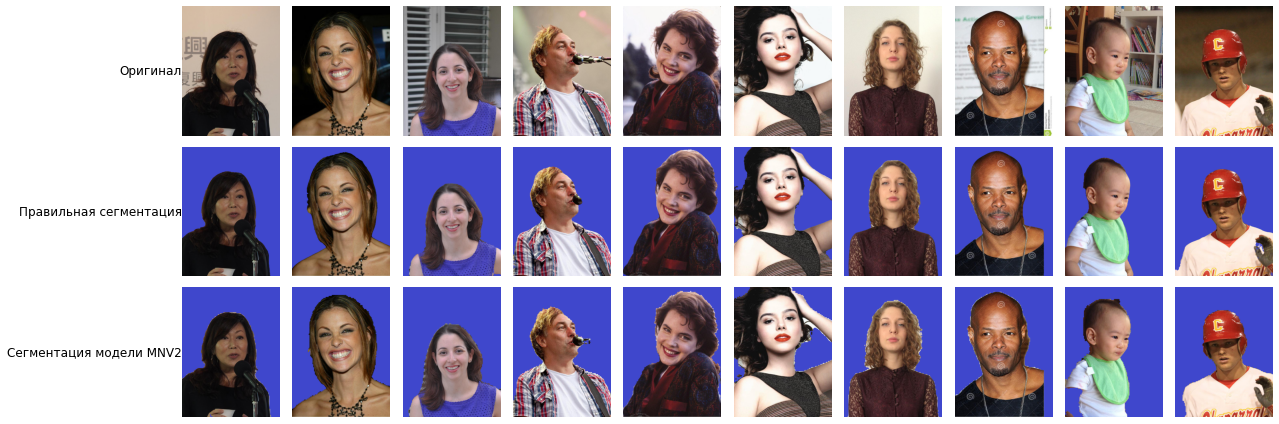

In [13]:
show_example(segMNV2)    

### MobileNet version 3

In [14]:
class SelfieSegMNV3:
    def __init__(self):
        self.dim = 224
        self.model = load_model("models/munet_mnv3_wm10.h5")

    def short_name(self):
        return "MNV3"

    def seg(self, rgb_image):
        image = Image.fromarray(rgb_image)
        
        width = image.width
        height = image.height

        image = image.resize((self.dim, self.dim), Image.ANTIALIAS)
        img = np.float32(np.array(image) / 255.0)
        img = img[:, :, 0:3]

        # Reshape input and threshold output
        out = self.model.predict(img.reshape(1, self.dim, self.dim, 3), verbose=0)
        
        out = np.float32((out > 0.5)).reshape(self.dim, self.dim)
        mask = (255 * out).astype("uint8")

        mask = cv2.resize(mask, (width, height))
        _, mask = cv2.threshold(mask, 128, 255, 0)

        return mask

In [15]:
segMNV3 = SelfieSegMNV3()

IoU 0.98
Time of segmentation 572 milliseconds
IoU 0.97
Time of segmentation 62 milliseconds
IoU 0.90
Time of segmentation 61 milliseconds
IoU 0.96
Time of segmentation 65 milliseconds
IoU 0.93
Time of segmentation 69 milliseconds
IoU 0.80
Time of segmentation 63 milliseconds
IoU 0.94
Time of segmentation 54 milliseconds
IoU 0.97
Time of segmentation 62 milliseconds
IoU 0.58
Time of segmentation 72 milliseconds
IoU 0.98
Time of segmentation 66 milliseconds


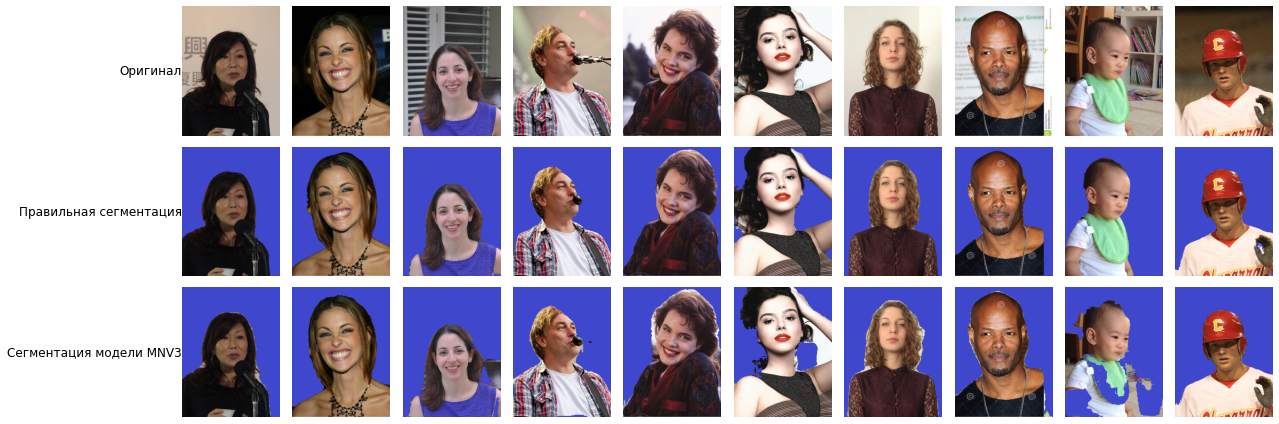

In [16]:
show_example(segMNV3)    

### PortraitNet

In [17]:
class SelfieSegPN:
    def __init__(self, with_prev = False):
        self.interpreter = tf.lite.Interpreter(model_path="models/portrait_video.tflite")  # Use 'tf.lite' on recent tf versions
        self.interpreter.allocate_tensors()
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()
        h, w = self.input_details[0]['shape'][1:3]
        self.dim = w
        self.with_prev = with_prev
        self.prev = np.zeros((self.dim, self.dim, 1))

    def short_name(self):
        return "PN"

    def normalize(self, imgOri, scale=1, mean=[103.94, 116.78, 123.68], val=[0.017, 0.017, 0.017]):
        img = np.array(imgOri.copy(), np.float32) / scale
        return (img - mean) * val

    def seg(self, frame):
        img = np.array(frame)
        
        width = img.shape[1]
        height = img.shape[0]
        
        img = cv2.resize(img, (self.dim, self.dim))
        img = img.astype(np.float32)

        img = self.normalize(img)

        # Add prior as fourth channel
        img = np.dstack([img, self.prev])
        img = img[np.newaxis, :, :, :]

        # Invoke interpreter for inference
        self.interpreter.set_tensor(self.input_details[0]['index'], np.array(img, dtype=np.float32))
        self.interpreter.invoke()
        out = self.interpreter.get_tensor(self.output_details[0]['index'])
        out = out.reshape(self.dim, self.dim, 1)
        out = (255 * out).astype("uint8")
        _, out = cv2.threshold(out, 128, 255, cv2.THRESH_BINARY)
        
        if self.with_prev:
            self.prev = (out / 255.0).astype("float32")

        mask = cv2.resize(out, (width, height))
        _, mask = cv2.threshold(mask, 128, 255, 0)

        return mask

In [18]:
segPN = SelfieSegPN()

IoU 0.99
Time of segmentation 16 milliseconds
IoU 0.97
Time of segmentation 17 milliseconds
IoU 0.98
Time of segmentation 18 milliseconds
IoU 0.97
Time of segmentation 16 milliseconds
IoU 0.97
Time of segmentation 16 milliseconds
IoU 0.96
Time of segmentation 21 milliseconds
IoU 0.96
Time of segmentation 17 milliseconds
IoU 0.94
Time of segmentation 21 milliseconds
IoU 0.97
Time of segmentation 21 milliseconds
IoU 0.97
Time of segmentation 21 milliseconds


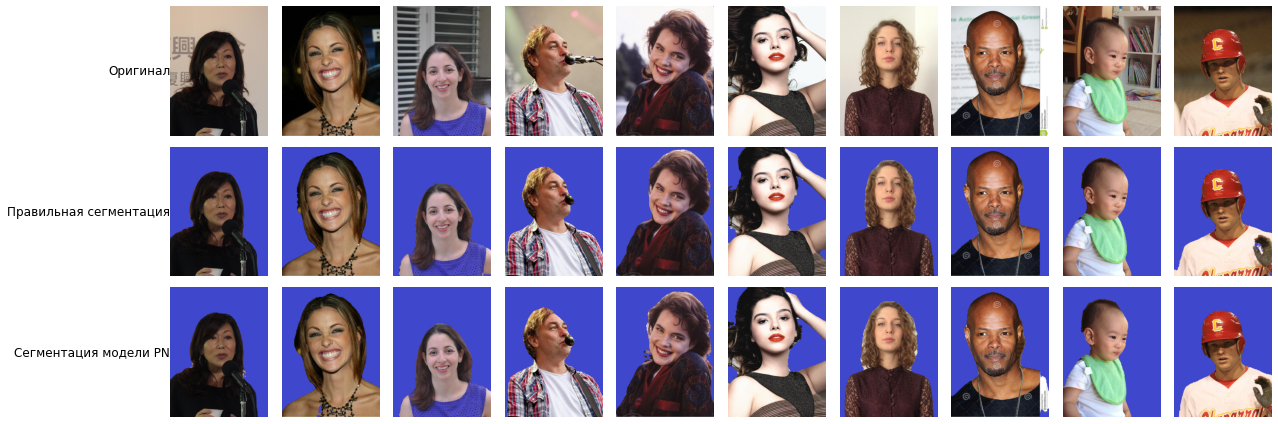

In [19]:
show_example(segPN)    

### SINet

In [20]:
class SelfieSegSN:
    def __init__(self):
        # Load the sinet pytorch model
        self.config = [[[3, 1], [5, 1]], [[3, 1], [3, 1]],
                  [[3, 1], [5, 1]], [[3, 1], [3, 1]], [[5, 1], [3, 2]], [[5, 2], [3, 4]],
                  [[3, 1], [3, 1]], [[5, 1], [5, 1]], [[3, 2], [3, 4]], [[3, 1], [5, 2]]]
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        self.model = SINet(classes=2, p=2, q=8, config=self.config, chnn=1)
        self.model.load_state_dict(torch.load('./models/model_296.pth', map_location=self.device))
        self.model.eval()

        # Enable gpu mode, if cuda available
        self.model.to(self.device)

        # Mean and std. deviation for normalization
        self.mean = [102.890434, 111.25247, 126.91212]
        self.std = [62.93292, 62.82138, 66.355705]
        self.dim = 320

    def short_name(self):
        return "SN"

    def seg(self, frame):
        img = np.array(frame)
        
        width = img.shape[1]
        height = img.shape[0]
        
        img = cv2.resize(img, (self.dim, self.dim))
        img = img.astype(np.float32)

        # Normalize and add batch dimension
        img = (img - self.mean) / self.std
        img /= 255
        img = img.transpose((2, 0, 1))
        img = img[np.newaxis, ...]

        # Load the inputs into GPU
        inps = torch.from_numpy(img).float().to(self.device)

        # Perform prediction and plot results
        with torch.no_grad():
            torch_res = self.model(inps)
            _, mask = torch.max(torch_res, 1)

        # Alpha blending with background image
        mask = mask.view(self.dim, self.dim, 1).cpu().numpy()
        mask = mask * 255
        mask = mask.reshape(self.dim, self.dim).astype("uint8")
        mask = cv2.resize(mask, (width, height))
        _, mask = cv2.threshold(mask, 128, 255, 0)

        return mask

In [21]:
segSN = SelfieSegSN()

SB Net Enc bracnch num :  2
SB Net Enc chnn num:  1
SINet Enc bracnch num :  2
SINet Enc chnn num:  1
This module has [[3, 1], [5, 1]]
This module has [[3, 1], [3, 1]]
This module has [[3, 1], [5, 1]]
This module has [[3, 1], [3, 1]]
This module has [[5, 1], [3, 2]]
This module has [[5, 2], [3, 4]]
This module has [[3, 1], [3, 1]]
This module has [[5, 1], [5, 1]]
This module has [[3, 2], [3, 4]]
This module has [[3, 1], [5, 2]]


IoU 0.99
Time of segmentation 138 milliseconds
IoU 0.98
Time of segmentation 47 milliseconds
IoU 0.98
Time of segmentation 50 milliseconds
IoU 0.98
Time of segmentation 47 milliseconds
IoU 0.98
Time of segmentation 46 milliseconds
IoU 0.89
Time of segmentation 47 milliseconds
IoU 0.98
Time of segmentation 48 milliseconds
IoU 0.98
Time of segmentation 40 milliseconds
IoU 0.98
Time of segmentation 55 milliseconds
IoU 0.98
Time of segmentation 40 milliseconds


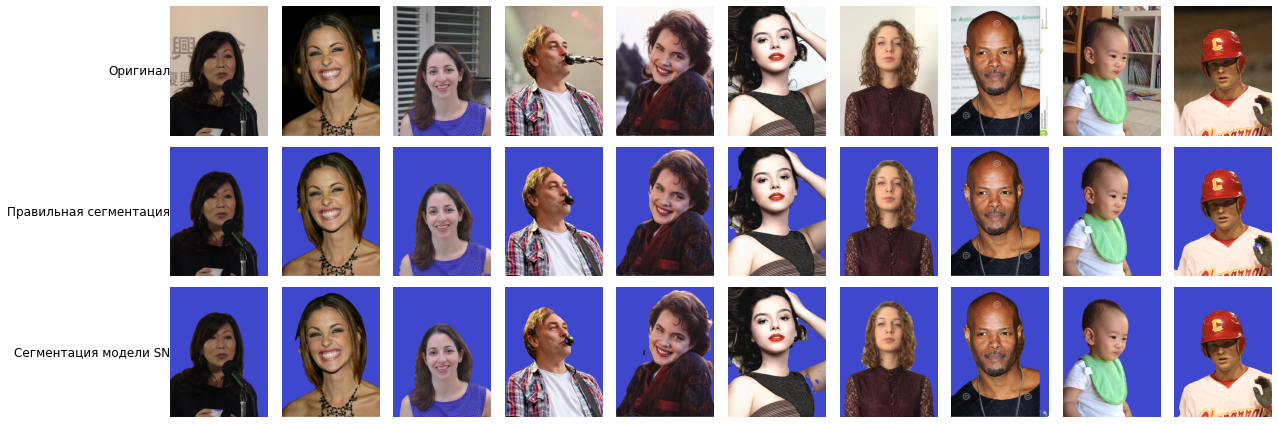

In [22]:
show_example(segSN)    

### Mediapipe

In [23]:
class SelfieSegMP:
    def __init__(self):
        self.mp_drawing = mp.solutions.drawing_utils
        self.mp_selfie_segmentation = mp.solutions.selfie_segmentation
        self.selfie_segmentation = self.mp_selfie_segmentation.SelfieSegmentation(model_selection=1)

    def short_name(self):
        return "MP"

    def seg(self, frame):
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        image.flags.writeable = False
        results = self.selfie_segmentation.process(image)

        mask = cv2.resize(results.segmentation_mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_CUBIC)
        mask = (255 * mask).astype("uint8")
        _, mask = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)

        return mask

In [24]:
segMP = SelfieSegMP()

IoU 0.99
Time of segmentation 19 milliseconds
IoU 0.98
Time of segmentation 5 milliseconds
IoU 0.97
Time of segmentation 5 milliseconds
IoU 0.96
Time of segmentation 5 milliseconds
IoU 0.93
Time of segmentation 0 milliseconds
IoU 0.87
Time of segmentation 5 milliseconds
IoU 0.96
Time of segmentation 0 milliseconds
IoU 0.95
Time of segmentation 0 milliseconds
IoU 0.97
Time of segmentation 6 milliseconds
IoU 0.98
Time of segmentation 0 milliseconds


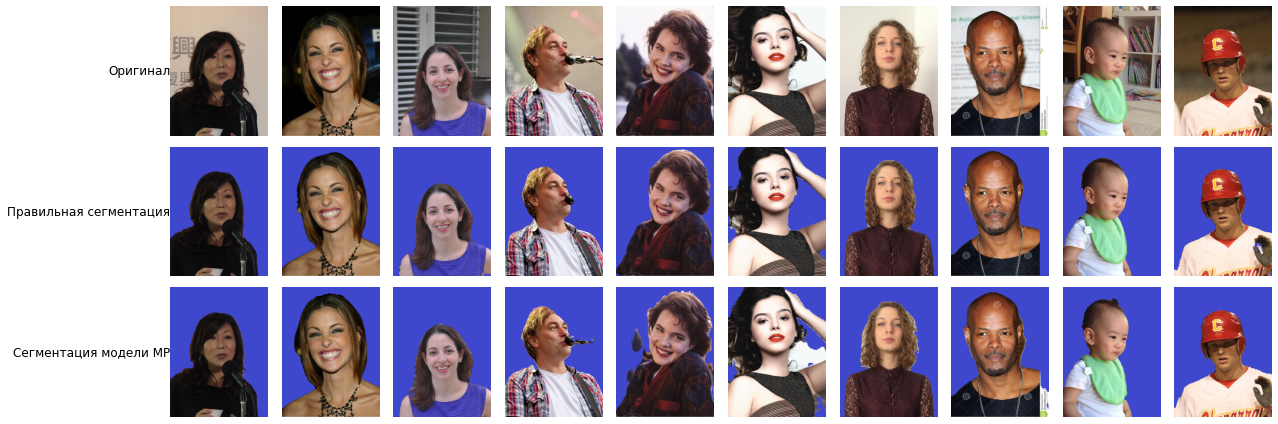

In [25]:
show_example(segMP)    

In [26]:
models = [segMNV2, segMNV3, segPN, segSN, segMP]

# Расчёт метрик качества

Функция расчёта метрик качества для конкретного примера

In [27]:
def IoUAndTime(model, image_mask_index):
    true_mask = get_true_mask(image_mask_index)
    
    pred_mask, calc_time = calc_pred_mask(model, image_mask_index)
    
    IoU = jaccard_score(true_mask, pred_mask, average="micro")
    
    return IoU, calc_time    

Пасчёт метрики качества для каждой модели для каждого изображения

In [32]:
for model in models:
    IoU_list = []
    calc_time_list = []
    print(model.short_name())
    for index in range(dataset_size):
        IoU, calc_time = IoUAndTime(model, index)
        IoU_list.append(IoU)
        calc_time_list.append(calc_time)
    
    image_mask_df['{}_IoU'.format(model.short_name())] = IoU_list
    image_mask_df['{}_calc_time'.format(model.short_name())] = calc_time_list
    

MNV2
MNV3
PN
SN
MP


In [92]:
image_mask_df.to_csv('result.csv')

### Сравнение статистических характеристик метрик качества моделей

In [83]:
model_names = [model.short_name() for model in models]

IoU

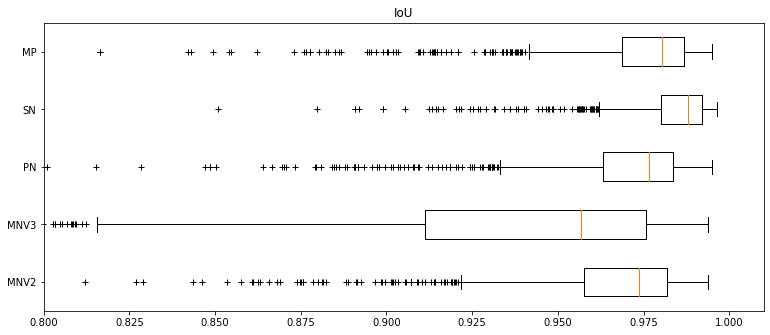

In [116]:
fig = plt.figure(figsize =(10, 4))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
ax.set_xlim([0.8, 1.01])
ax.set_title("IoU")

iou_with_model_names = ['{}_IoU'.format(model_name) for model_name in model_names]
bp = ax.boxplot(image_mask_df[iou_with_model_names], labels=model_names, 
                sym = '+', vert=False,)

plt.show()

In [114]:
IoU_stat_df = pd.DataFrame(index=["Mean", "High whisker", "Q3", "Median", "Q1", "Low whisker"])
for model in models:
    model_stats = []
    stats = boxplot_stats(image_mask_df["{}_IoU".format(model.short_name())])[0]
    model_stats.append(stats["mean"])
    model_stats.append(stats["whishi"])
    model_stats.append(stats["q3"])
    model_stats.append(stats["med"])
    model_stats.append(stats["q1"])
    model_stats.append(stats["whislo"])
    IoU_stat_df[model.short_name()] = model_stats
pd.set_option("display.precision", 3)
IoU_stat_df

MNV2   MNV3     PN     SN     MP
Mean          0.964  0.925  0.965  0.983  0.972
High whisker  0.994  0.994  0.995  0.997  0.995
Q3            0.982  0.976  0.983  0.992  0.987
Median        0.974  0.957  0.977  0.988  0.981
Q1            0.958  0.911  0.963  0.980  0.969
Low whisker   0.922  0.815  0.933  0.962  0.942

In [115]:
IoU_stat_df.to_csv("IoU.csv")

Время расчёта маски

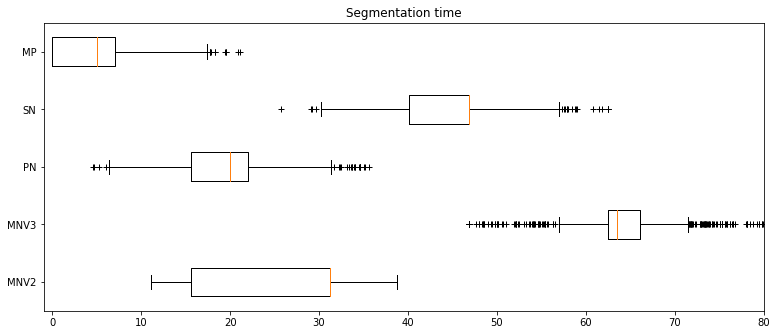

In [152]:
fig = plt.figure(figsize =(10, 4))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
ax.set_xlim([-1, 80])
ax.set_title("Segmentation time")
calc_time_with_model_names = ['{}_calc_time'.format(model_name) for model_name in model_names]
bp = ax.boxplot(image_mask_df[calc_time_with_model_names], labels=model_names, 
                sym = '+', vert=False)
plt.show()

In [121]:
calc_time_stat_df = pd.DataFrame(index=["Mean", "High whisker", "Q3", "Median", "Q1", "Low whisker"])
for model in models:
    model_stats = []
    stats = boxplot_stats(image_mask_df["{}_calc_time".format(model.short_name())])[0]
    model_stats.append(stats["mean"])
    model_stats.append(stats["whishi"])
    model_stats.append(stats["q3"])
    model_stats.append(stats["med"])
    model_stats.append(stats["q1"])
    model_stats.append(stats["whislo"])
    calc_time_stat_df[model.short_name()] = model_stats
pd.set_option("display.precision", 0)
calc_time_stat_df

MNV2  MNV3  PN  SN  MP
Mean            25    65  20  43   6
High whisker    39    71  31  57  17
Q3              31    66  22  47   7
Median          31    64  20  47   5
Q1              16    62  16  40   0
Low whisker     11    57   6  30   0

In [122]:
calc_time_stat_df.to_csv("calc_time.csv")

### Примеры худшей сегментации 

In [149]:
def show_all_models_example(image_mask_index):
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
    bgd = cv2.imread('./img/background.jpg')
    bgd = cv2.cvtColor(bgd, cv2.COLOR_BGR2RGB)
    bgd = cv2.resize(bgd, (600, 800))
    
    #row_titles = [, "Правильная сегментация", "Сегментация модели {}".format(model.short_name())]
    #for ax, row_title in zip(axs[:,0], row_titles):
    #    ax.annotate(row_title, xy=(0, 0.5), xytext=(0, 0.5), xycoords='axes fraction', textcoords='axes fraction',
    #                size='large', ha='right', va='center')
    ax = axs[0]
    ax.set_title("Оригинал")
    rgb_image = plt.imread(image_mask_df.iloc[image_mask_index]['image_path'])
    ax.imshow(rgb_image)
    ax.axis('off')
    
    ax = axs[1]
    ax.set_title("Правильная сегментация")
    true_mask = get_true_mask(image_mask_index)
    segmented_selfie_true = merge_with_background(rgb_image, true_mask, bgd)
    ax.imshow(segmented_selfie_true)
    ax.axis('off')
    
    for ax_col_index, model in zip(range(2, 5), [segSN, segMP]):
        ax = axs[ax_col_index]
        IoU = image_mask_df.loc[image_mask_index]['{}_IoU'.format(model.short_name())]
        ax.set_title("{}, IoU={:.2f}".format(model.short_name(), IoU))
        pred_mask, calc_time = calc_pred_mask(model, image_mask_index)
        segmented_selfie_pred = merge_with_background(rgb_image, pred_mask, bgd)
        ax.imshow(segmented_selfie_pred)
        ax.axis('off')
        
    fig.tight_layout()
    plt.show()

Примеры худшей сегментации модели SINet

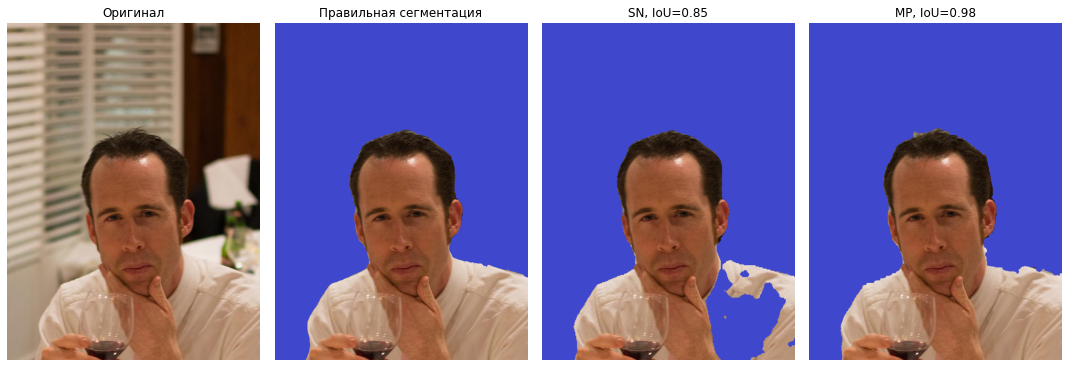

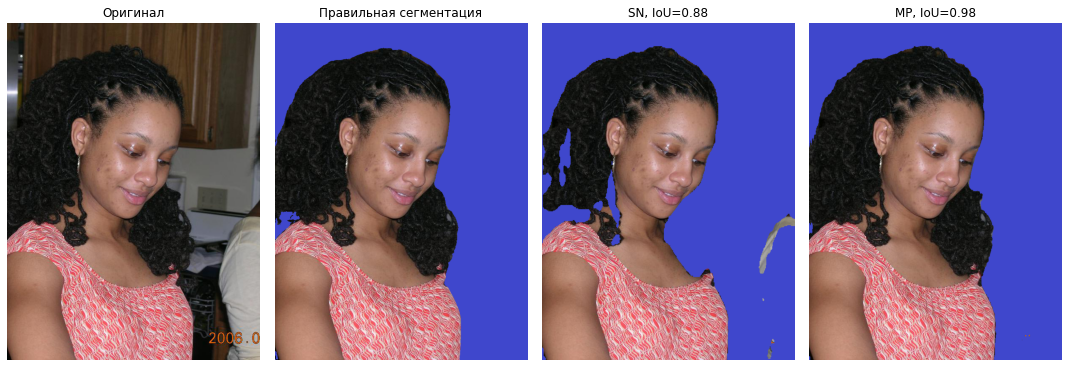

In [151]:
for index in image_mask_df.sort_values('SN_IoU').index[:2]:
    show_all_models_example(index)

Примеры худшей сегментации модели SINet

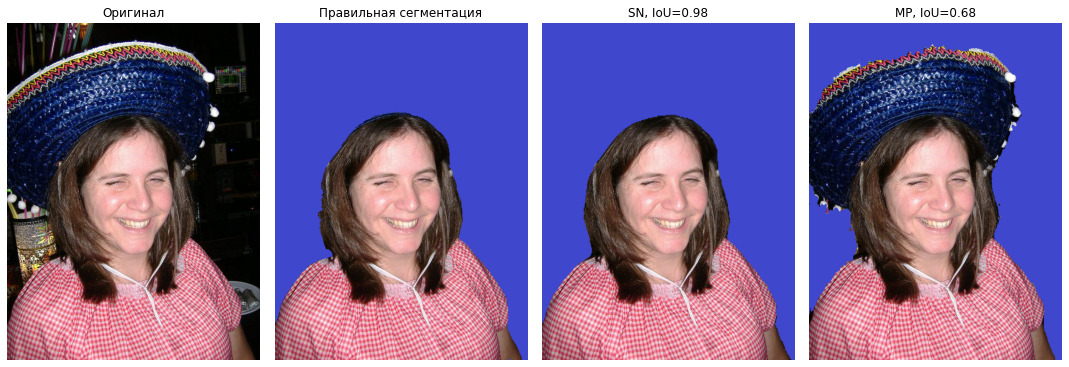

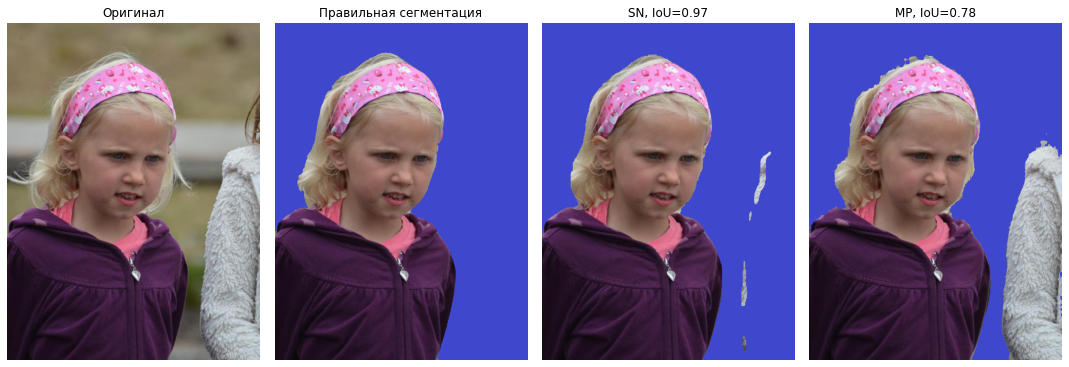

In [155]:
for index in image_mask_df.sort_values('MP_IoU').index[:2]:
    show_all_models_example(index)